In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

In [6]:
def intial_condition(x,y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

def boundary_condition(x,y,t, custom_value):
    return torch.full_like(x, custom_value)

In [7]:
def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad = True)
    y = torch.rand(num_points, 1, requires_grad = True)
    t = torch.rand(num_points, 1, requires_grad = True)
    
    return x,y,t

In [8]:
def generate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0,1.0]).repeat(num_points//2)
    y_boundary = torch.rand(num_points)
    
    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary,x_boundary
        
    return x_boundary.view(-1,1), y_boundary.view(-1,1)


def generate_boundary_training_data(num_points):
    x_boundary, y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points, 1, requires_grad= True)
    
    return x_boundary, y_boundary, t

In [9]:
def pde(x,y,t,model):
    input_data = torch.cat([x,y,t],dim=1)
    u = model(input_data)
    u_x,u_y = torch.autograd.grad(u,[x,y],grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True) 
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y,y,grad_outputs= torch.ones_like(u_y), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = 1 * u_xx + 1 * u_yy - u_t
    return heat_eq_residual

In [10]:
def train_PINN(model, num_iterations, num_points):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    for  iteration in range(num_iterations):
        optimizer.zero_grad()
        
        x,y,t = generate_training_data(num_points)
        
        x_b,y_b,t_b = generate_boundary_training_data(num_points)
        
        t_intial = torch.zeros_like(t)
        u_intial = intial_condition(x,y)
        
        custom_value = 0
        u_boundary_x = boundary_condition(x_b,y_b,t_b,custom_value)
        u_boundary_y = boundary_condition(y_b,x_b,t_b,custom_value)
        
        residual = pde(x,y,t,model)
        
        loss =  nn.MSELoss()(u_intial, model(torch.cat([x,y,t_intial], dim=1))) + \
                nn.MSELoss()(u_boundary_x, model(torch.cat([x_b,y_b,t_b], dim=1))) + \
                nn.MSELoss()(u_boundary_y, model(torch.cat([y_b,x_b,t_b], dim=1))) + \
                nn.MSELoss()(residual, torch.zeros_like(residual))
                
        loss.backward()
        optimizer.step()
        
        if iteration % 100 ==0:
            print("itration",iteration, "loss",loss )

In [11]:
model = PINN()
num_iterations = 10000
num_points = 1000
train_PINN(model,num_iterations,num_points)

itration 0 loss tensor(0.8722, grad_fn=<AddBackward0>)
itration 100 loss tensor(0.1362, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.1209, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.1210, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.1188, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.1155, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.1071, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0973, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0865, grad_fn=<AddBackward0>)
itration 900 loss tensor(0.0760, grad_fn=<AddBackward0>)
itration 1000 loss tensor(0.0679, grad_fn=<AddBackward0>)
itration 1100 loss tensor(0.0641, grad_fn=<AddBackward0>)
itration 1200 loss tensor(0.0566, grad_fn=<AddBackward0>)
itration 1300 loss tensor(0.0529, grad_fn=<AddBackward0>)
itration 1400 loss tensor(0.0474, grad_fn=<AddBackward0>)
itration 1500 loss tensor(0.0456, grad_fn=<AddBackward0>)
itration 1600 loss tensor(0.0420, grad_fn=<AddBackward0>)
itration 1700 loss tensor(

/opt/anaconda3/envs/PINN_course/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


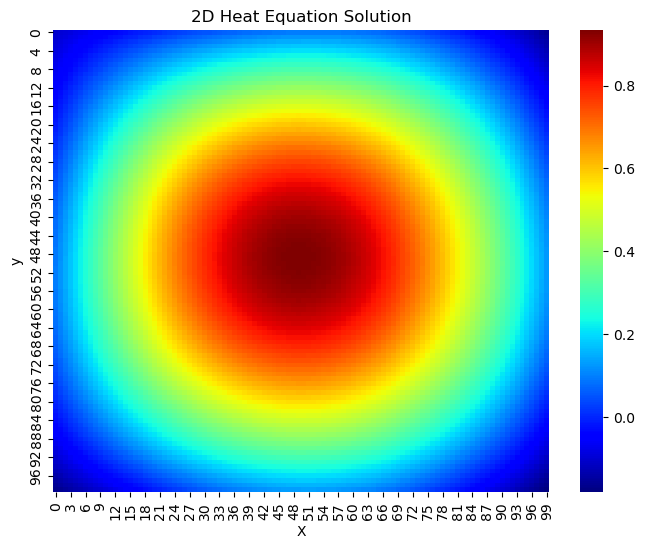

In [12]:
with torch.no_grad():
    x_vals = torch.linspace(0,1,100)
    y_vals = torch.linspace(0,1,100)
    X, Y = torch.meshgrid(x_vals,y_vals)
    t_val = torch.ones_like(X) * 0 # spacify the time
    
    input_data = torch.stack([X.flatten(),Y.flatten(),t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape,Y.shape)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(solution, cmap="jet")
    plt.title("2D Heat Equation Solution")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

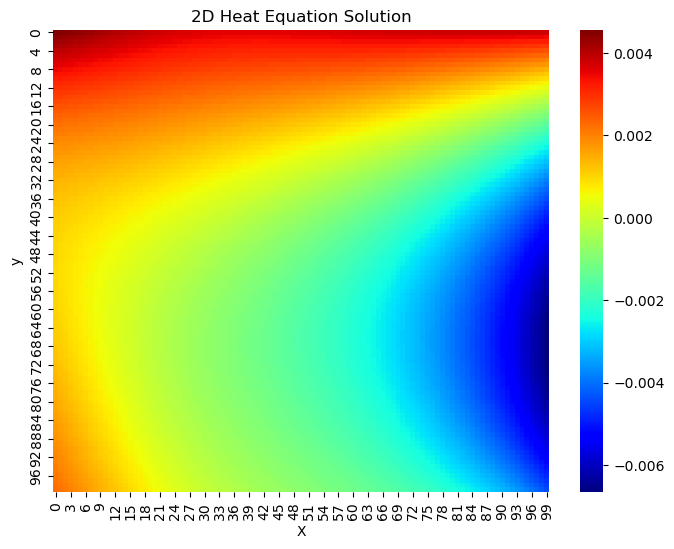

In [13]:
with torch.no_grad():
    x_vals = torch.linspace(0,1,100)
    y_vals = torch.linspace(0,1,100)
    X, Y = torch.meshgrid(x_vals,y_vals)
    t_val = torch.ones_like(X) * 1 # spacify the time
    
    input_data = torch.stack([X.flatten(),Y.flatten(),t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape,Y.shape)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(solution, cmap="jet")
    plt.title("2D Heat Equation Solution")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()